In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
from matplotlib import pyplot as plt

In [1]:
! wget http://aws.acecrc.org.au/data/AmeryG3_antarctic_aws_1999_2017.nc

--2018-11-12 20:03:53--  http://aws.acecrc.org.au/data/AmeryG3_antarctic_aws_1999_2017.nc
Resolving aws.acecrc.org.au (aws.acecrc.org.au)... 144.6.226.118
Connecting to aws.acecrc.org.au (aws.acecrc.org.au)|144.6.226.118|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9260468 (8.8M) [application/x-netcdf]
Saving to: ‘AmeryG3_antarctic_aws_1999_2017.nc’

AmeryG3_antarctic_a 100%[===================>]   8.83M  4.31MB/s    in 2.0s    

2018-11-12 20:03:56 (4.31 MB/s) - ‘AmeryG3_antarctic_aws_1999_2017.nc’ saved [9260468/9260468]



In [1]:
import xarray as xr
import pandas as pd
AmeryAWS = xr.open_dataset('AmeryG3_antarctic_aws_1999_2017.nc')
AmeryAWS.Time
AmeryAWS = AmeryAWS.swap_dims({'time':'Time'})

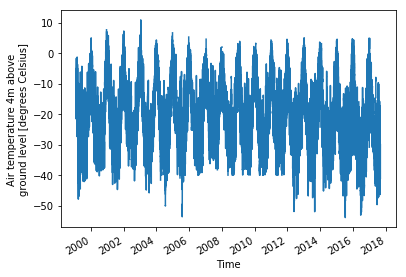

In [2]:
%matplotlib inline
AiT4 = AmeryAWS.AiT4
AiT1 = AmeryAWS.AiT1
AiT4.plot()

In [3]:
import pandas as pd
nclist = {}
ncnames = {}
ncurls = {}
for year in range(1999,2017):
    nclist[year] = pd.read_csv('patmosx_list_'+str(year)+'.txt', sep='\s+')
    ncnames[year] = nclist[year].Name
    ncurls[year] = "https://www.ncei.noaa.gov/data/avhrr-reflectance-cloud-properties-patmos-extended/access/"+ str(year)+"/"+ncnames[year]

In [4]:
ncurls[1999][0]

'https://www.ncei.noaa.gov/data/avhrr-reflectance-cloud-properties-patmos-extended/access/1999/patmosx_v05r03_NOAA-14_asc_d19990101_c20140314.nc'

In [3]:
import dask.array as da
import numpy as np
import xarray as xr

<xarray.DataArray ()>
array(<built-in method values of dict object at 0x7f0eeb615c18>, dtype=object)

In [6]:
import pandas as pd
url_list = pd.read_csv('patmosx_daplist.csv',skipinitialspace=True)
url_list = url_list['Name'][10374:10374+365]
url_list = 'http://www.ncei.noaa.gov/thredds/dodsC/avhrr-patmos-x-cloudprops-noaa-asc-fc/files/' + url_list
#urls = 'http://www.ncei.noaa.gov/thredds/dodsC/avhrr-patmos-x-cloudprops-noaa-asc-fc/files/1999/patmosx_v05r03_NOAA-14_asc_d19990101_c20140314.nc'
#http://www.ncei.noaa.gov/thredds/dodsC/avhrr-patmos-x-cloudprops-noaa-asc-fc/files/1999/patmosx_v05r03_NOAA-14_asc_d19990102_c20140316.nc?cloud_fraction[0:1:0][0:1:0][0:1:0],latitude[0:1:1799],longitude[0:1:3599],time[0:1:0]

In [7]:
ds = xr.open_mfdataset(url_list, chunks=10**9, mask_and_scale=True)

In [9]:
ds

<xarray.Dataset>
Dimensions:                        (latitude: 1800, longitude: 3600, time: 365)
Coordinates:
  * latitude                       (latitude) float32 -89.947815 -89.84893 ...
  * longitude                      (longitude) float32 -179.94507 -179.84619 ...
  * time                           (time) datetime64[ns] 1999-01-02 ...
Data variables:
    acha_info                      (time, latitude, longitude) uint8 dask.array<shape=(365, 1800, 3600), chunksize=(1, 1800, 3600)>
    acha_quality                   (time, latitude, longitude) uint8 dask.array<shape=(365, 1800, 3600), chunksize=(1, 1800, 3600)>
    bad_pixel_mask                 (time, latitude, longitude) float32 dask.array<shape=(365, 1800, 3600), chunksize=(1, 1800, 3600)>
    cld_emiss_acha                 (time, latitude, longitude) float32 dask.array<shape=(365, 1800, 3600), chunksize=(1, 1800, 3600)>
    cld_height_acha                (time, latitude, longitude) float32 dask.array<shape=(365, 1800, 3600), chu

In [69]:
cloud_fract = ds.cloud_fraction.sel(latitude=slice(-75,-65),longitude=slice(50,85))-0.5
cloud_fract.to_netcdf('cloud_fract','w')

/opt/conda/lib/python3.6/site-packages/xarray/core/dataarray.py:1638: SerializationWarning: saving variable latitude with floating point data as an integer dtype without any _FillValue to use for NaNs
  return dataset.to_netcdf(*args, **kwargs)
/opt/conda/lib/python3.6/site-packages/xarray/core/dataarray.py:1638: SerializationWarning: saving variable longitude with floating point data as an integer dtype without any _FillValue to use for NaNs
  return dataset.to_netcdf(*args, **kwargs)


In [12]:
%matplotlib inline
cloud_fract_arealmean = cloud_fract.mean(dim=('latitude','longitude'))
                                         

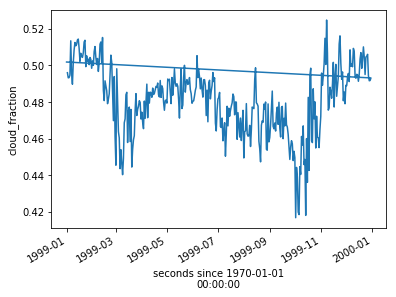

In [13]:
cloud_fract_arealmean.plot()

In [68]:
percent_cloudy = ((cloud_fract.where(cloud_fract>0.5).count(dim=('latitude','longitude')))/cloud_fract.count(dim=('latitude','longitude')))
percent_cloudy.to_netcdf(path='percent_cloudy',mode='w')

/opt/conda/lib/python3.6/site-packages/dask/local.py:255: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


In [34]:
#((cloud_fract.sel(time='1999-06-24').where(cloud_fract>0.5).count())/cloud_fract.sel(time='1999-06-24').count()).compute()

<xarray.DataArray 'cloud_fraction' ()>
array(0.233)

/opt/conda/lib/python3.6/site-packages/dask/local.py:255: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


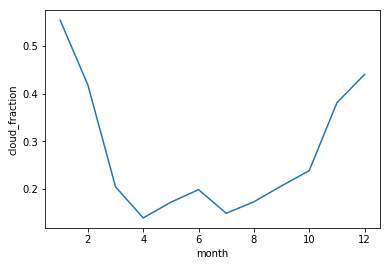

In [65]:
percent_cloudy.groupby(percent_cloudy.time.dt.month).mean().plot()